# NLP for Stock Market Prediction
Author: Antonio Stark, Sasha Pukhova, Frank Looi, Precious Enharo

Kaggle challenge: https://www.kaggle.com/aaron7sun/stocknews
Kaggle article: https://www.kaggle.com/rahulvarma9595/nlp-for-stock-market-predictions

## Import packages and libraries

In [1]:
# import packages
import pandas as pd
import numpy as np
import string
import time
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec, KeyedVectors
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

## Import data

In [2]:
# import data
data = pd.read_csv('Combined_News_DJIA.csv')

print('data is %d data points with %d features'%(data.shape[0],data.shape[1]))
data.head()

data is 1989 data points with 27 features


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,08/08/2008,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,11/08/2008,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,12/08/2008,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,13/08/2008,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,14/08/2008,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

## Data preprocessing
### Data cleaning & tokenization & normalization

In [3]:
# data cleaning & tokenization & normalization
## create copy of original dataframe
dataClean = data.copy()

## create set for stopwords as dictionaries are faster
stops = set(stopwords.words('english'))

# news header you want to test
## (2,5) is interesting to see how "Al-Qa'eda" gets transferred
## (4,3) is interesting to see how numbers are encoded
## (2,15) is interesting to see how both numbers ('55') and hyphens ('mega-city') are encoded
## (1988,24) gives a bug for replacing numbers and removing stop words
tester = (2,15)

for i in range(2,data.shape[1]):
    if i==tester[1]:
        print('Original text:')
        print(dataClean.iloc[tester[0],i])
    
    # data cleaning
    ## remove 'b'' at the start and ''' at the end
    dataClean.iloc[:,i]=dataClean.iloc[:,i].str.strip("b'")
    if i==tester[1]:
        print('\nCleaned text:')
        print(dataClean.iloc[tester[0],i])
    
    ## remove punctuation
    dataClean.iloc[:,i]=dataClean.iloc[:,i].str.translate(str.maketrans('', '', string.punctuation))
    if i==tester[1]:
        print('\nPunctuations removed:')
        print(dataClean.iloc[tester[0],i])
        
    # normalization
    ## make lowercase
    dataClean.iloc[:,i]=dataClean.iloc[:,i].str.lower()
    if i==tester[1]:
        print('\nLowercase:')
        print(dataClean.iloc[tester[0],i])
    
    # tokenization
    ## word_tokenize version (buggy) is below
    dataClean.iloc[:,i]=dataClean.iloc[:,i].str.split()
    if i==tester[1]:
        print('\nTokenized:')
        print(dataClean.iloc[tester[0],i])
        
    # replace numbers
    dataClean.iloc[:,i]=dataClean.iloc[:,i].apply(lambda sent: 'num' if isinstance(sent,float) else ['num' if token.isdigit() else token for token in sent])
    if i==tester[1]:
        print('\nReplaced numbers:')
        print(dataClean.iloc[tester[0],i])
        print()
        
    # remove stop words
    dataClean.iloc[:,i]=dataClean.iloc[:,i].apply(lambda sent: [token for token in sent if token not in stops])
    if i==tester[1]:
        print('\nRemoved stop words:')
        print(dataClean.iloc[tester[0],i])
        

Original text:
b'55 pyramids as large as the Luxor stacked into a mega-city pyramid in Tokyo Bay'

Cleaned text:
55 pyramids as large as the Luxor stacked into a mega-city pyramid in Tokyo Bay

Punctuations removed:
55 pyramids as large as the Luxor stacked into a megacity pyramid in Tokyo Bay

Lowercase:
55 pyramids as large as the luxor stacked into a megacity pyramid in tokyo bay

Tokenized:
['55', 'pyramids', 'as', 'large', 'as', 'the', 'luxor', 'stacked', 'into', 'a', 'megacity', 'pyramid', 'in', 'tokyo', 'bay']

Replaced numbers:
['num', 'pyramids', 'as', 'large', 'as', 'the', 'luxor', 'stacked', 'into', 'a', 'megacity', 'pyramid', 'in', 'tokyo', 'bay']


Removed stop words:
['num', 'pyramids', 'large', 'luxor', 'stacked', 'megacity', 'pyramid', 'tokyo', 'bay']


In [4]:
dataClean.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,08/08/2008,0,"[georgia, downs, two, russian, warplanes, coun...","[breaking, musharraf, impeached]","[russia, today, columns, troops, roll, south, ...","[russian, tanks, moving, towards, capital, sou...","[afghan, children, raped, impunity, un, offici...","[num, russian, tanks, entered, south, ossetia,...","[breaking, georgia, invades, south, ossetia, r...","[enemy, combatent, trials, nothing, sham, sali...",...,"[georgia, invades, south, ossetia, russia, get...","[alqaeda, faces, islamist, backlash]","[condoleezza, rice, us, would, act, prevent, i...","[busy, day, european, union, approved, new, sa...","[georgia, withdraw, num, soldiers, iraq, help,...","[pentagon, thinks, attacking, iran, bad, idea,...","[caucasus, crisis, georgia, invades, south, os...","[indian, shoe, manufactory, series, like, work]","[visitors, suffering, mental, illnesses, banne...","[help, mexicos, kidnapping, surge]"
1,11/08/2008,1,"[wont, america, nato, help, us, wont, help, us...","[bush, puts, foot, georgian, conflict]","[jewish, georgian, minister, thanks, israeli, ...","[georgian, army, flees, disarray, russians, ad...","[olympic, opening, ceremony, fireworks, faked]","[mossad, fraudulent, new, zealand, passports, ...","[russia, angered, israeli, military, sale, geo...","[american, citizen, living, sossetia, blames, ...",...,"[israel, us, behind, georgian, aggression]","[believe, tv, neither, russian, georgian, much...","[riots, still, going, montreal, canada, police...","[china, overtake, us, largest, manufacturer]","[war, south, ossetia, pics]","[israeli, physicians, group, condemns, state, ...","[russia, beaten, united, states, head, peak, oil]","[perhaps, question, georgia, russia, conflict]","[russia, much, better, war]","[come, trading, sex, food]"
2,12/08/2008,0,"[remember, adorable, 9yearold, sang, opening, ...","[russia, ends, georgia, operation]","[sexual, harassment, would, children]","[alqaeda, losing, support, iraq, brutal, crack...","[ceasefire, georgia, putin, outmaneuvers, west]","[microsoft, intel, tried, kill, xo, num, laptop]","[stratfor, russogeorgian, war, balance, power]","[im, trying, get, sense, whole, georgiarussia,...",...,"[us, troops, still, georgia, know, georgia, fi...","[russias, response, georgia, right]","[gorbachev, accuses, us, making, serious, blun...","[russia, georgia, nato, cold, war, two]","[remember, adorable, 62yearold, led, country, ...","[war, georgia, israeli, connection]","[signs, point, us, encouraging, georgia, invad...","[christopher, king, argues, us, nato, behind, ...","[america, new, mexico]","[bbc, news, asiapacific, extinction, man, clim..."
3,13/08/2008,0,"[us, refuses, israel, weapons, attack, iran, r...","[president, ordered, attack, tskhinvali, capit...","[israel, clears, troops, killed, reuters, came...","[britains, policy, tough, drugs, pointless, sa...","[body, num, year, old, found, trunk, latest, r...","[china, moved, num, million, quake, survivors,...","[bush, announces, operation, get, russias, gri...","[russian, forces, sink, georgian, ships]",...,"[elephants, extinct, num]","[us, humanitarian, missions, soon, georgia, ru...","[georgias, ddos, came, us, sources]","[russian, convoy, heads, georgia, violating, t...","[israeli, defence, minister, us, strike, iran]","[gorbachev, choice]","[witness, russian, forces, head, towards, tbil...","[quarter, russians, blame, us, conflict, poll]","[georgian, president, says, us, military, take...","[num, nobel, laureate, aleksander, solzhenitsy..."
4,14/08/2008,1,"[experts, admit, legalise, drugs]","[war, south, osetia, num, pictures, made, russ...","[swedish, wrestler, ara, abrahamian, throws, a...","[russia, exaggerated, death, toll, south, osse...","[missile, killed, num, inside, pakistan, may, ...","[rushdie, condemns, random, houses, refusal, p...","[poland, us, agree, missle, defense, deal, int...","[russians, conquer, tbli

### Stemming, lemmatization, canonicalization

In [5]:
# Stemming/lemmatization/canonicalization - Frank

# do either stemming or lemmatization
stemming = False # converted philippines to philippin in (4,25)
lemmatization = True # converts to proper words but philippine? (4,25)

dataNormal = dataClean.copy()
tester = (0,5) 
print('Original text:')
print(data.iloc[tester[0],tester[1]])
print('\nCleaned text:')
print(dataClean.iloc[tester[0],tester[1]])

if stemming:
    porter = PorterStemmer()   
    for i in range(2,dataNormal.shape[1]):
        dataNormal.iloc[:,i]=dataNormal.iloc[:,i].apply(lambda x: [porter.stem(y) for y in x])
    print('\nAfter stemming:')
    print(dataNormal.iloc[tester[0],tester[1]])
elif lemmatization:
    lemmatizer = WordNetLemmatizer()
    for i in range(2,data.shape[1]):
        dataNormal.iloc[:,i]=dataNormal.iloc[:,i].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
    print('\nAfter lemmatization:')
    print(dataNormal.iloc[tester[0],tester[1]])
        
print('\ndataNormal:')
dataNormal.head()

Original text:
b'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire'

Cleaned text:
['russian', 'tanks', 'moving', 'towards', 'capital', 'south', 'ossetia', 'reportedly', 'completely', 'destroyed', 'georgian', 'artillery', 'fire']

After lemmatization:
['russian', 'tank', 'moving', 'towards', 'capital', 'south', 'ossetia', 'reportedly', 'completely', 'destroyed', 'georgian', 'artillery', 'fire']

dataNormal:


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,08/08/2008,0,"[georgia, down, two, russian, warplane, countr...","[breaking, musharraf, impeached]","[russia, today, column, troop, roll, south, os...","[russian, tank, moving, towards, capital, sout...","[afghan, child, raped, impunity, un, official,...","[num, russian, tank, entered, south, ossetia, ...","[breaking, georgia, invades, south, ossetia, r...","[enemy, combatent, trial, nothing, sham, salim...",...,"[georgia, invades, south, ossetia, russia, get...","[alqaeda, face, islamist, backlash]","[condoleezza, rice, u, would, act, prevent, is...","[busy, day, european, union, approved, new, sa...","[georgia, withdraw, num, soldier, iraq, help, ...","[pentagon, think, attacking, iran, bad, idea, ...","[caucasus, crisis, georgia, invades, south, os...","[indian, shoe, manufactory, series, like, work]","[visitor, suffering, mental, illness, banned, ...","[help, mexico, kidnapping, surge]"
1,11/08/2008,1,"[wont, america, nato, help, u, wont, help, u, ...","[bush, put, foot, georgian, conflict]","[jewish, georgian, minister, thanks, israeli, ...","[georgian, army, flees, disarray, russian, adv...","[olympic, opening, ceremony, firework, faked]","[mossad, fraudulent, new, zealand, passport, i...","[russia, angered, israeli, military, sale, geo...","[american, citizen, living, sossetia, blame, u...",...,"[israel, u, behind, georgian, aggression]","[believe, tv, neither, russian, georgian, much...","[riot, still, going, montreal, canada, police,...","[china, overtake, u, largest, manufacturer]","[war, south, ossetia, pic]","[israeli, physician, group, condemns, state, t...","[russia, beaten, united, state, head, peak, oil]","[perhaps, question, georgia, russia, conflict]","[russia, much, better, war]","[come, trading, sex, food]"
2,12/08/2008,0,"[remember, adorable, 9yearold, sang, opening, ...","[russia, end, georgia, operation]","[sexual, harassment, would, child]","[alqaeda, losing, support, iraq, brutal, crack...","[ceasefire, georgia, putin, outmaneuvers, west]","[microsoft, intel, tried, kill, xo, num, laptop]","[stratfor, russogeorgian, war, balance, power]","[im, trying, get, sense, whole, georgiarussia,...",...,"[u, troop, still, georgia, know, georgia, firs...","[russia, response, georgia, right]","[gorbachev, accuses, u, making, serious, blund...","[russia, georgia, nato, cold, war, two]","[remember, adorable, 62yearold, led, country, ...","[war, georgia, israeli, connection]","[sign, point, u, encouraging, georgia, invade,...","[christopher, king, argues, u, nato, behind, g...","[america, new, mexico]","[bbc, news, asiapacific, extinction, man, clim..."
3,13/08/2008,0,"[u, refuse, israel, weapon, attack, iran, report]","[president, ordered, attack, tskhinvali, capit...","[israel, clear, troop, killed, reuters, camera...","[britain, policy, tough, drug, pointless, say,...","[body, num, year, old, found, trunk, latest, r...","[china, moved, num, million, quake, survivor, ...","[bush, announces, operation, get, russia, gril...","[russian, force, sink, georgian, ship]",...,"[elephant, extinct, num]","[u, humanitarian, mission, soon, georgia, russ...","[georgia, ddos, came, u, source]","[russian, convoy, head, georgia, violating, tr...","[israeli, defence, minister, u, strike, iran]","[gorbachev, choice]","[witness, russian, force, head, towards, tbili...","[quarter, russian, blame, u, conflict, poll]","[georgian, president, say, u, military, take, ...","[num, nobel, laureate, aleksander, solzhenitsy..."
4,14/08/2008,1,"[expert, admit, legalise, drug]","[war, south, osetia, num, picture, made, russi...","[swedish, wrestler, ara, abrahamian, throw, aw...","[russia, exaggerated, death, toll, south, osse...","[missile, killed, num, inside, pakistan, may, ...","[rushdie, condemns, random, house, refusal, pu...","[poland, u, agree, missle, defense, deal, inte...","[russian, conquer, tblisi, bet, seriously, bet]"

## Convert words to vectors
### Combine all header words in each date into a single datapoint (flattening)

In [20]:
dataFlat = dataNormal.iloc[:,0:2].copy()

# combine the words in each date into a single datapoint
combined = dataNormal.iloc[:,3].values.tolist()

for i in range(0,dataNormal.shape[0]):
    for j in range (3,dataNormal.shape[1]):
        combined[i] += dataNormal.iloc[i,j]

dataFlat['Combined'] = combined
print('dataFlat is %d data points with %d features'%(dataFlat.shape[0],dataFlat.shape[1]))
print('dataFlat:')
dataFlat.head()

dataFlat is 1989 data points with 3 features
dataFlat:


,Date,Label,Combined
0,08/08/2008,0,"[breaking, musharraf, impeached, breaking, mus..."
1,11/08/2008,1,"[bush, put, foot, georgian, conflict, bush, pu..."
2,12/08/2008,0,"[russia, end, georgia, operation, russia, end,..."
3,13/08/2008,0,"[president, ordered, attack, tskhinvali, capit..."
4,14/08/2008,1,"[war, south, osetia, num, picture, made, russi..."


### Implement word2vec model

In [7]:
# create word2vec model
## details on parameters, see documentation: https://radimrehurek.com/gensim/models/word2vec.html
num_size = 100        # Word vector dimensionality                    
num_min_count = 5     # Minimum frequency of a word to be included in dictionary                       
num_workers = 4       # Number of threads to run in parallel

start_time = time.time()
model = Word2Vec(dataFlat['Combined'], size=num_size, min_count=num_min_count, workers=num_workers)
end_time = time.time()
## save model for future use
model.save('w2v-combined-vector-size100-count5-workers4')

## print resulting matrix size
print('W2V model (vocabulary) is %d words with %d dimensions'%(model.wv.vectors.shape[0],model.wv.vectors.shape[1]))
print('training time: %.3f seconds'%(end_time-start_time))

W2V model (vocabulary) is 10197 words with 100 dimensions
training time: 1.485 seconds


### test word2vec model

In [8]:
# look up most similar words
w1 = 'war'
topN = 5
print('Top %d words most similar to \'%s\':'%(topN,w1))
topSimWords = model.wv.most_similar(positive=[w1],topn=topN)
for i in range(0,len(topSimWords)):
    print('   \'%s\': %.4f'%(topSimWords[i][0],topSimWords[i][1]))

# test similarities between words
w1 = 'war'
w2 = 'peace'
w3 = 'terror'
w4 = 'school'
print('\nSimilarity between \'%s\' and \'%s\': %.3f'%(w1,w2,model.wv.similarity(w1=w1,w2=w2)))
print('Similarity between \'%s\' and \'%s\': %.3f'%(w1,w3,model.wv.similarity(w1=w1,w2=w3)))
print('Similarity between \'%s\' and \'%s\': %.3f'%(w2,w4,model.wv.similarity(w1=w2,w2=w4)))

Top 5 words most similar to 'war':
   'humanity': 0.7297
   'cartel': 0.6937
   'iraq': 0.6732
   'end': 0.6655
   'conflict': 0.6417

Similarity between 'war' and 'peace': 0.523
Similarity between 'war' and 'terror': 0.419
Similarity between 'peace' and 'school': 0.159


### Create average vector per each date

In [9]:
# list of words in the model
words = model.wv.vocab.keys()
print('\'words\' is a %s of %d words in the W2V model'%(type(words),0))

averages = [None]*len(dataFlat)

for i in range(len(dataFlat)): 
    #For each row=date (total of 1989)
    
    # collate all the words in each date that is in the 'words' vocabulary
    ## find & save the vector format of that word
    words_in_date = [model[word] for word in dataFlat['Combined'][i] if word in words]
    
    # find the averages of the words in the dates that are also in the W2V model
    averages[i] = np.mean(np.array(words_in_date),axis=0)

dataVector = dataFlat.copy()
dataVector['Average'] = averages
print('dataVector is %d data points with %d features'%(dataVector.shape[0],dataVector.shape[1]))
print('dataVector:')
dataVector.head()

'words' is a <class 'dict_keys'> of 0 words in the W2V model


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


dataVector is 1989 data points with 4 features
dataVector:


,Date,Label,Combined,Average
0,08/08/2008,0,"[breaking, musharraf, impeached, breaking, mus...","[0.2583413, -0.6409775, -0.35101673, 0.2027861..."
1,11/08/2008,1,"[bush, put, foot, georgian, conflict, bush, pu...","[0.26899585, -0.64693755, -0.2777465, 0.177095..."
2,12/08/2008,0,"[russia, end, georgia, operation, russia, end,...","[0.2542796, -0.66929936, -0.323633, 0.1358186,..."
3,13/08/2008,0,"[president, ordered, attack, tskhinvali, capit...","[0.26202416, -0.65403086, -0.3510077, 0.221222..."
4,14/08/2008,1,"[war, south, osetia, num, picture, made, russi...","[0.25109062, -0.65059984, -0.343325, 0.2128067..."


In [10]:
# test output the average vector for a given date
testDate = '11/08/2008'
testVector = dataVector.loc[dataVector['Date']==testDate]['Average'].iloc[0]
print('\'testVector\' of date %s is a %s, a vector of %d dimensions'%(testDate,type(testVector),testVector.size))

'testVector' of date 11/08/2008 is a <class 'numpy.ndarray'>, a vector of 100 dimensions


### Create version of dataframe for modelling & testing

In [11]:
# New dataframe must have each vector dimension be its own column
dataModel = dataVector.copy()
dataModel = pd.merge(dataModel,dataModel.Average.apply(pd.Series),right_index=True,left_index=True)
dataModel = dataModel.drop(columns=['Combined','Average'])

print('dataModel is %d data points with %d features'%(dataModel.shape[0],dataModel.shape[1]))
print('dataModel:')
dataModel.head()

dataModel is 1989 data points with 102 features
dataModel:


,Date,Label,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,08/08/2008,0,0.258341,-0.640978,-0.351017,0.202786,0.478725,0.383579,-0.182533,0.367297,...,-0.533181,0.506373,0.015191,-0.270074,0.307611,-0.058040,0.034013,0.177675,-0.501269,-0.010133
1,11/08/2008,1,0.268996,-0.646938,-0.277746,0.177096,0.467887,0.375053,-0.105752,0.269850,...,-0.513657,0.436148,0.051383,-0.202498,0.318145,-0.023796,0.069445,0.196699,-0.505480,0.029238
2,12/08/2008,0,0.254280,-0.669299,-0.323633,0.135819,0.472930,0.396447,-0.146869,0.341994,...,-0.566750,0.451785,-0.013610,-0.215131,0.294626,-0.072856,0.030046,0.220963,-0.514773,0.048635
3,13/08/2008,0,0.262024,-0.654031,-0.351008,0.221223,0.423667,0.464353,-0.136328,0.375479,...,-0.476154,0.474902,0.028545,-0.248658,0.344339,-0.104652,0.005338,0.288933,-0.504079,-0.015509
4,14/08/2008,1,0.251091,-0.650600,-0.343325,0.212807,0.455867,0.305038,-0.153649,0.354632,...,-0.559770,0.493122,0.003519,-0.236039,0.281939,-0.000292,0.041074,0.099882,-0.461887,-0.020591


In [12]:
# Extensions:
## Parts of speech (POS)
## Named entity recognition (NER)
## Coreference resolution

# Modeling

### Train/test dataset splitting

In [13]:
# split data into train/test sets by date
splitDate = '31/12/2014'
splitLoc = dataModel.index[dataModel['Date']==splitDate][0]
print('corresponding index of split date = %s is %d'%(splitDate,splitLoc))

X_train = dataModel.iloc[:splitLoc,:].drop(columns=['Date','Label'])
X_test = dataModel.iloc[splitLoc:,:].drop(columns=['Date','Label'])
y_train = dataModel.iloc[:splitLoc,:]['Label']
y_test = dataModel.iloc[splitLoc:,:]['Label']

print('\nX_train is %d data points, X_test is %d data points, both with %d features'%(X_train.shape[0],X_test.shape[0],X_train.shape[1]))
print('split ratio is training set: %.1f%% to testing set: %.1f%%'%(X_train.shape[0]/dataModel.shape[0]*100,X_test.shape[0]/dataModel.shape[0]*100))

corresponding index of split date = 31/12/2014 is 1610

X_train is 1610 data points, X_test is 379 data points, both with 100 features
split ratio is training set: 80.9% to testing set: 19.1%


### Train and test models

In [23]:
# plot ROC curve
def ROCplot(modelType,y_test,y_score):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr,tpr)
    plt.title('Receiver Operating Characteristic for %s'%(modelType))
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

models = ['RF','XGB','LogReg','SVC','MLP']
    
def predModel(X_train, y_train, X_test, y_test, modelType=models[0]):
    if modelType not in models:
        print('Error: model not in predefined list')
        return
    
    start_time = time.time()
    if modelType == models[0]:
        rf = RandomForestClassifier(n_jobs=2, random_state=0)
        rf.fit(X_train, y_train)        
        end_time = time.time()
        # predict for X_test
        y_pred = rf.predict(X_test)
        # predict probabilities for test data
        ## keep probabilities for positive class only
        y_score = rf.predict_proba(X_test)[:,1]
        
    elif modelType == models[1]:
        xgb = XGBClassifier(objective = 'binary:logistic')
        xgb.fit(X_train, y_train)
        end_time = time.time()
        # predict for X_test
        y_pred = xgb.predict(X_test)
        # predict probabilities for test data
        ## keep probabilities for positive class only
        y_score = xgb.predict_proba(X_test)[:,1]
        
    elif modelType == models[2]:
        lg = LogisticRegression(penalty='l1', C=1.5, solver='liblinear', max_iter=100, n_jobs=-1)
        lg.fit(X_train, y_train)
        end_time = time.time()        
        # predict for X_test
        y_pred = lg.predict(X_test)
        # predict probabilities for test data
        y_score = lg.decision_function(X_test)
        
    elif modelType == models[3]:
        clf = SVC(gamma='auto')
        clf.fit(X_train, y_train)
        end_time = time.time()
        # predict for X_test
        y_pred = clf.predict(X_test)
        # predict probabilities for test data
        y_score = clf.decision_function(X_test)
        
    elif modelType == models[4]:
        clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
        clf.fit(X_train, y_train)
        end_time = time.time()
        # predict for X_test
        y_pred = clf.predict(X_test)
        # predict probabilities for test data
        ## keep probabilities for positive class only
        y_score = clf.predict_proba(X_test)[:,1]
    
    print('Accuracy for model %s is: %.2f'%(modelType,accuracy_score(y_test,y_pred)))
    print('ROC AUC for model %s is: %.2f'%(modelType,roc_auc_score(y_test, y_pred)))
    print('Model training time is %.3f seconds'%(end_time-start_time))
    print('\nConfusion matrix:')
    print(confusion_matrix(y_test,y_pred))
    ROCplot(modelType,y_test,y_score)   

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy for model RF is: 0.51
ROC AUC for model RF is: 0.51
Model training time is 0.108 seconds

Confusion matrix:
[[95 92]
 [94 98]]


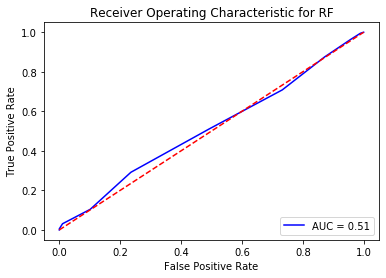

In [24]:
predModel(X_train, y_train, X_test, y_test, modelType='RF')

Accuracy for model XGB is: 0.47
ROC AUC for model XGB is: 0.46
Model training time is 1.228 seconds

Confusion matrix:
[[ 50 137]
 [ 65 127]]


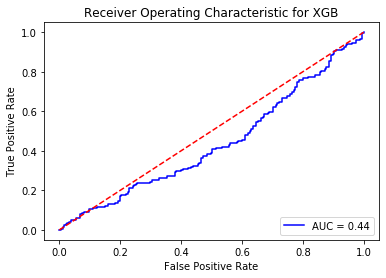

In [25]:
predModel(X_train, y_train, X_test, y_test, modelType='XGB')

Accuracy for model LogReg is: 0.51
ROC AUC for model LogReg is: 0.50
Model training time is 0.011 seconds

Confusion matrix:
[[  0 187]
 [  0 192]]


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


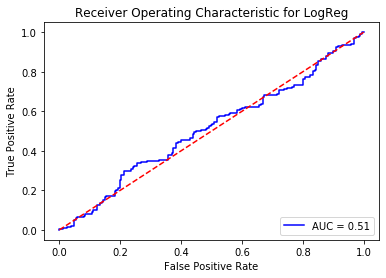

In [26]:
predModel(X_train, y_train, X_test, y_test, modelType='LogReg')

Accuracy for model SVC is: 0.51
ROC AUC for model SVC is: 0.50
Model training time is 0.283 seconds

Confusion matrix:
[[  0 187]
 [  0 192]]


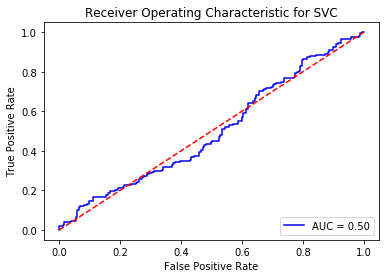

In [27]:
predModel(X_train, y_train, X_test, y_test, modelType='SVC')

Accuracy for model MLP is: 0.51
ROC AUC for model MLP is: 0.50
Model training time is 0.006 seconds

Confusion matrix:
[[  0 187]
 [  0 192]]


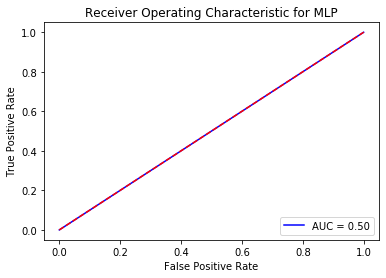

In [28]:
predModel(X_train, y_train, X_test, y_test, modelType='MLP')

### print output